In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import time

import pandas as pd

In [3]:
path = "/home/borowis/s3"
bs = 512

In [4]:
trans = transforms.Compose([
    transforms.RandomAffine(10, shear=5),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = ImageFolder(path + "/train_data/medium", trans)
train_loader = DataLoader(train_data, bs, shuffle=True, num_workers=8)

In [5]:
val_data = ImageFolder(path + "/validation_classification/medium", trans)
val_loader = DataLoader(val_data, bs, shuffle=True, num_workers=8)

In [6]:
class SimpleNet(nn.Module):
        
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.05))

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.fc1 = nn.Linear(4 * 4 * 128, 4096)
        self.drop_out = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(4096, 2300)
        
    def forward(self, x):
        
        x = self.layer1(x) #32
        x = self.layer2(x) #16
        x = self.layer3(x) #16
        x = self.layer4(x) #8
        x = self.layer5(x) #4
        x = self.layer6(x) #4

        #Reshape data to input to the input layer of the neural net
        #Size changes from (128, 4, 4) to (1, 2048)
        x = x.view(-1, 128 * 4 * 4)
        x = self.drop_out(x)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 2048) to (1, 2300)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [7]:
model = SimpleNet()

criterion = nn.CrossEntropyLoss()
print(model)

optimizer = optim.Adam(model.parameters())

SimpleNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.05)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2,

In [8]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.cuda()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   
        data = data.cuda()
        target = target.long().cuda()

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [9]:
def test_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.cuda()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.cuda()
            target = target.long().cuda()

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Validation Loss: ', running_loss)
        print('Validation Accuracy: ', acc, '%')
        return running_loss, acc

In [10]:
n_epochs = 3
train_loss = []
val_loss = []
val_acc = []

In [14]:
for i in range(10, 14):
    tl = train_epoch(model, train_loader, criterion, optimizer)
    vl, va = test_model(model, val_loader, criterion)
    
    train_loss.append(tl)
    val_loss.append(vl)
    val_acc.append(va)
    print('='*20)
    
    # https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/16
    torch.save({
        'epoch': i + 1,
        'state_dict': model.state_dict(),
        'best_acc': val_acc,
        'optimizer' : optimizer.state_dict(),
    }, path + "/models/" + str(i) + ".pth")

Training Loss:  1.8521987147824108 Time:  182.17037987709045 s
Validation Loss:  1.8081870211495294
Validation Accuracy:  62.00825907411433 %
Training Loss:  1.803182540023015 Time:  182.1845645904541 s
Validation Loss:  1.7465719514422946
Validation Accuracy:  63.22538578569876 %
Training Loss:  1.7553735068844978 Time:  182.2491316795349 s
Validation Loss:  1.764078974723816
Validation Accuracy:  63.72527711367094 %
Training Loss:  1.7138970868376688 Time:  182.23750281333923 s
Validation Loss:  1.7149067984686956
Validation Accuracy:  63.507933058030865 %


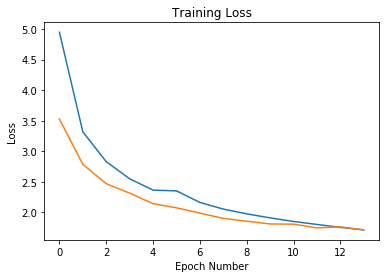

In [15]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)

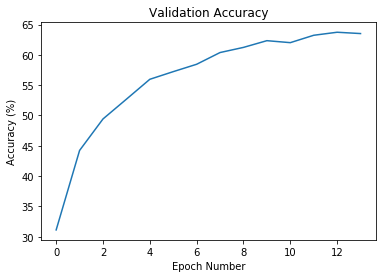

In [16]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(val_acc)

In [17]:
checkpoint = torch.load(path + "/models/11.pth")
model.load_state_dict(checkpoint["state_dict"])

In [18]:
test_trans = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_data = ImageFolder(path + "/test_classification", test_trans)
test_loader = DataLoader(test_data, shuffle = False, batch_size = bs, num_workers = 8)

In [19]:
def inference(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.cuda()

        preds = []
        for batch_idx, data in enumerate(test_loader):   
            data = data[0].cuda()
            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            preds.append(predicted.cpu().numpy())

        return np.concatenate(preds)

In [20]:
preds = inference(model, test_loader)

In [21]:
class_to_idx = train_data.class_to_idx
idx_to_class = {val: key for key, val in class_to_idx.items()}

In [22]:
ids = []
for idx, (pred, (file, _)) in enumerate(zip(preds, test_data.samples)):
    file_name = file[file.rfind('/') + 1 : file.rfind('.')]
    ids.append(int(file_name))

In [23]:
submit = pd.DataFrame({'label': preds}, index=ids)

submit.label = submit.label.map(idx_to_class)
submit.sort_index().head(20)

,label
0,1613
1,1364
2,1467
3,970
4,505
5,1040
6,1669
7,2182
8,1163
9,974


In [24]:
submit.sort_index().to_csv(path + "/model2.csv", index=True, index_label='id')